In [2]:
!pip install scipy

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal.windows import gaussian
from scipy.ndimage import gaussian_filter

def praat_spectrogram(
    filepath,
    sr=None,
    window_length_sec=0.005,
    hop_length_sec=0.002,
    max_freq=5000,
    dynamic_range=50,
    preemph_cutoff=50,
    cmap='gray_r',
    interpolation='bilinear',
    dpi=200,
    show_colorbar=True,
    show_plot=True,
    save_path=None
):
    """
    Generate a Praat-like spectrogram with smooth visual output.

    Parameters:
        filepath (str): Path to audio file.
        sr (int or None): Sample rate (None = use original).
        window_length_sec (float): Gaussian window length in seconds.
        hop_length_sec (float): Time step in seconds.
        max_freq (float): Max frequency for y-axis in Hz.
        dynamic_range (float): Display dynamic range in dB.
        preemph_cutoff (float): High-pass pre-emphasis cutoff in Hz.
        cmap (str): Matplotlib colormap.
        interpolation (str): Interpolation method for imshow (e.g., 'bilinear').
        dpi (int): Figure resolution.
        show_colorbar (bool): Whether to display colorbar.
        show_plot (bool): Whether to display plot.
        save_path (str or None): If set, saves figure to this path.

    Returns:
        S_db_smooth (np.ndarray): Smoothed spectrogram in dB.
        sr (int): Sample rate.
    """

    import librosa.display  # needed for axis labels

    # Load audio
    y, sr = librosa.load(filepath, sr=sr)

    # Apply pre-emphasis filter
    pre_emph_coeff = np.exp(-2 * np.pi * preemph_cutoff / sr)
    y = np.append(y[0], y[1:] - pre_emph_coeff * y[:-1])

    # Compute STFT
    win_length = int(window_length_sec * sr)
    hop_length = int(hop_length_sec * sr)
    n_fft = 2 ** int(np.ceil(np.log2(win_length)))
    window = gaussian(win_length, std=win_length / 6)

    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Apply dynamic range threshold
    S_db[S_db < (np.max(S_db) - dynamic_range)] = np.max(S_db) - dynamic_range

    # Smoothing (Praat-like)
    sigma_time = 0.0025 / hop_length_sec     # in frames
    sigma_freq = 1.5                         # in bins
    S_db_smooth = gaussian_filter(S_db, sigma=[sigma_freq, sigma_time])

    # Prepare axes for imshow
    duration = len(y) / sr
    times = np.linspace(0, duration, S_db_smooth.shape[1])
    freqs = np.linspace(0, sr / 2, S_db_smooth.shape[0])

    # Plot
    if show_plot or save_path:
        fig, ax = plt.subplots(figsize=(10, 4), dpi=dpi)
        img = ax.imshow(S_db_smooth,
                        origin='lower',
                        aspect='auto',
                        interpolation=interpolation,
                        cmap=cmap,
                        extent=[times[0], times[-1], freqs[0], freqs[-1]])

        ax.set_title("Praat-like Spectrogram (Smoothed)")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_ylim(0, max_freq)

        if show_colorbar:
            fig.colorbar(img, ax=ax, label='dB')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        if show_plot:
            plt.show()
        else:
            plt.close()

    return S_db_smooth, sr


In [8]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

example = librosa.example('libri1')

In [9]:
example

'/root/.cache/librosa/5703-47212-0000.ogg'

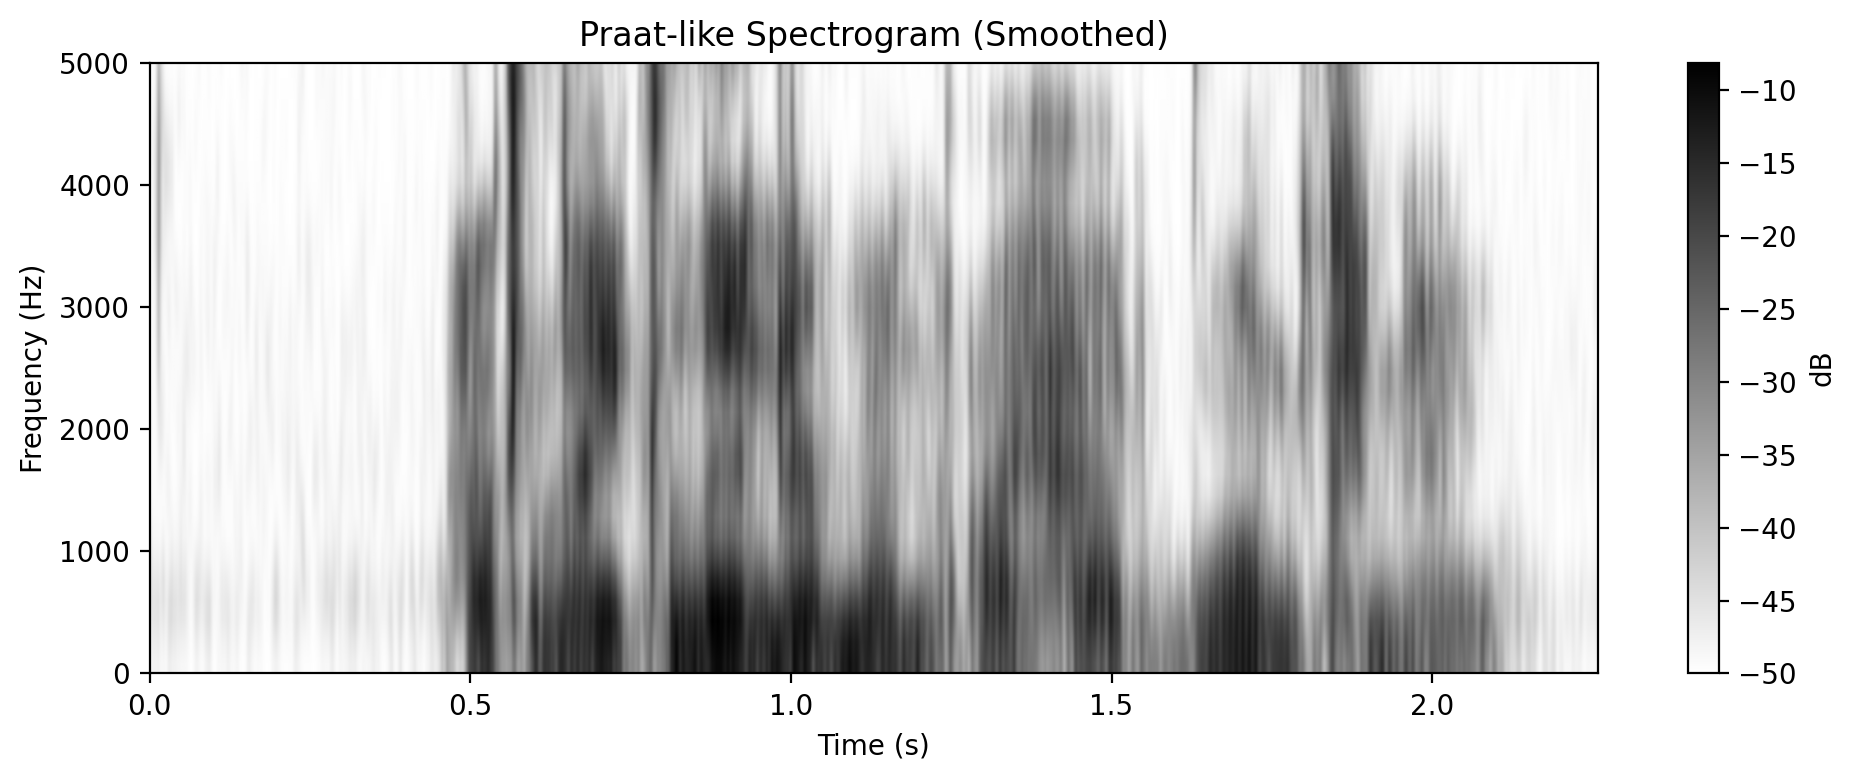

(array([[-48.15809081, -48.1617387 , -47.92955885, ..., -48.21726247,
         -48.1323376 , -48.40236203],
        [-47.0420728 , -47.19642475, -47.05223442, ..., -47.32015157,
         -47.28994957, -47.70311053],
        [-45.48054842, -45.93038204, -46.02792547, ..., -46.35760412,
         -46.43325781, -47.0279105 ],
        ...,
        [-49.92486894, -49.95629255, -49.98545508, ..., -50.        ,
         -50.        , -50.        ],
        [-49.86891401, -49.92374079, -49.97462254, ..., -50.        ,
         -50.        , -50.        ],
        [-49.82366885, -49.89741944, -49.96586335, ..., -50.        ,
         -50.        , -50.        ]]),
 44100)

In [19]:
praat_spectrogram("testclip.wav")